In [9]:
import scipy as sci
import matplotlib.pyplot as plt
import wfdb
import pandas as pd
%matplotlib inline

# Single Record Example

In [10]:
data_dir = 'MIT-BIH-Arrhythmia/'
record = '213'
ext = 'atr'

annot = wfdb.rdann(data_dir+record,ext)
annot_str = pd.DataFrame({'index':annot.sample,'sym':annot.symbol})
annot_str['sym'].value_counts()

N    2641
F     362
V     220
+      43
A      25
a       3
Name: sym, dtype: int64

In [17]:
data = wfdb.rdsamp(data_dir + record)
type(data)
n = 1000
data_str = pd.DataFrame({'channel1':data.adc()[:,0],'channel2':data.adc()[:,1]})

x = annot_str['index'][10]

fig,ax_array = plt.subplots(nrows=2,ncols=1)
#ax_array[0].scatter(range(100),data.adc()[x-50:x+50,0])
ax_array[0].scatter(range(n),data.adc()[0:n,0])
ax_array[1].scatter(range(n),data.adc()[0:n,1])

for i in annot_str['index'][annot_str['index'] < n]:
    ax_array[0].axvline(x=i,c='r')
    ax_array[1].axvline(x=i,c='r')
ax1 = ax_array[0]
ax1.set_title('ECG Signal with Event Annotations')

AttributeError: 'tuple' object has no attribute 'adc'

In [4]:
pd.DataFrame(sci.diff(annot_str[10:]['index'])).describe()

,0
count,3283.000000
mean,197.424002
std,19.094203
min,68.000000
25%,195.000000
50%,199.000000
75%,204.000000
max,323.000000


# Data Generation

In [5]:
import scipy as sci
import matplotlib.pyplot as plt
import wfdb
import pandas as pd

import os
import json

class MIT_BIH_parse(object):
    """This class reads and processes ECG signals from MIT-BIH Arrhythmia dataset and labels into batches.

    Data batches account for class imbalance (most heartbeats are normal) by a parameter alpha between 0 and 1. 
    Each batch consists of an approximate proportion (alpha) of positive samples.

    The data batches are windows centered around beat annotations. The size of the window is controlled by the             window_size parameter"""
    def __init__(self,window_size):
        """For each record number, there is a data sample with metadata, and an annotation. In aggregate, these
        are stored in the all_patients_data dict. The key is the record number, and the value is a pair(record,annot),          where record is the data sample object and annot is the annotation object. """
        # Data Parameters
        self.data_dir = 'MIT-BIH/'
        
        self.record_numbers = set(map(lambda x: x.split('.')[0], os.listdir('MIT-BIH/')))
        self.all_patients_data = dict([(record_num,[]) for record_num in self.record_numbers])

        # Model Parameters
        self.window_size = window_size

        self.alpha = 0.5

    def read_all_records(self):
        """Aggregates data from all records into a [m,n,2] pseudoimage"""
        for r in self.record_numbers:
            self.read_single_record(r)

    def read_single_record(self,record_num):
        """Updates the records dictionary with data from a given record number. 
        The data_dir should contain the .atr, .dat, and .hea files."""
        try:
            sample = wfdb.rdsamp(self.data_dir + record_num)
            annot = wfdb.rdann(self.data_dir + record_num,'atr')
        except ValueError:
            raise ValueError('Record not found') 

        validation_index = sci.random.choice(range(len(annot.sample)))
        self.all_patients_data[str(record_num)] = (sample,annot,)

    def get_data_obj(self,record_num):
        """Returns the data object for the given record."""
        return self.all_patients_data[str(record_num)][0]

    def get_annot_obj(self,record_num):
        """Returns the data object for the given record."""
        return self.all_patients_data[str(record_num)][1]

    def generate_data_batch(self,record_num,n=100,channel=0):
        """Returns data batch of ECG signals centered on heartbeat. Default n=100, channel=1."""
        if not self.all_patients_data[str(record_num)]:
            print('Patient number ' + str(record_num) + 'has not been read')
            return
        else:
            ch = sci.array(self.get_data_obj(record_num).adc()[:,channel])
            idx = sci.array(self.get_annot_obj(record_num).sample)
            label = sci.array(self.get_annot_obj(record_num).symbol)

            pos_ind = sci.where(label != 'N')[0]
            neg_ind = sci.where(label == 'N')[0]
            num_pos = pos_ind.size
            num_neg = neg_ind.size
            

            # (label, window) kv pairs
            data = []
            k = 0
            while k < int(n/2):
                j = sci.random.choice(pos_ind)
                # Check that the image covers the window
                if not (int(idx[j]+self.window_size/2) < ch.size and int(idx[j]-self.window_size/2) > 0):
                    continue
                data.append((int(idx[j]),label[j],
                             [int(i) for i in ch[(int(idx[j]-self.window_size/2)):(int(idx[j]+self.window_size/2))]]))
                k += 1

            k = 0
            while k < int(n/2):
                j = sci.random.choice(neg_ind)
                # Check that the image covers the window
                if not (int(idx[j]+self.window_size/2) < ch.size and int(idx[j]-self.window_size/2) > 0):
                    continue
                data.append((int(idx[j]),label[j],
                             [int(i) for i in ch[(int(idx[j]-self.window_size/2)):(int(idx[j]+self.window_size/2))]]))
                k += 1

            return data
        
    def toJSON(self,record_num,n=100,channel=0):
        """Return a sample of windows in JSON"""
        return json.dumps(self.generate_data_batch(record_num,n,channel))

In [6]:
data = MIT_BIH_parse(400)
#data.read_single_record('213')
#dat = data.generate_data_batch('213',100)
data.read_all_records()

fp = open('data.json','w')
fp.write(data.toJSON('213'))
fp.close()

V


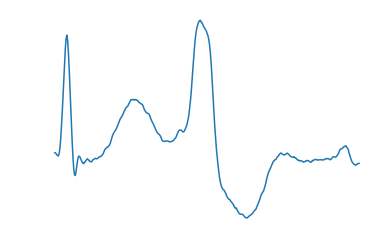

In [34]:
d = data.generate_data_batch('213')
print(d[2][1])
plt.plot(d[2][2])
plt.axis('off')
plt.savefig('pvc.svg')

# Data Visualization

Ex Number: 80
Label: N


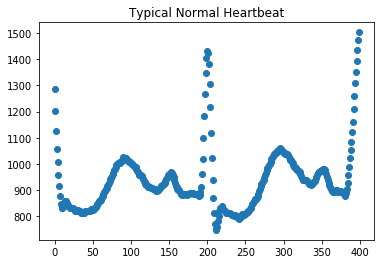

In [109]:
k = 80
print('Ex Number: ' + str(k))
print('Label: ' + str(dat[k][1]))

plt.scatter(range(len(dat[k][2])),dat[k][2])
plt.title('Typical Normal Heartbeat')

Ex Number: 3
Label: V


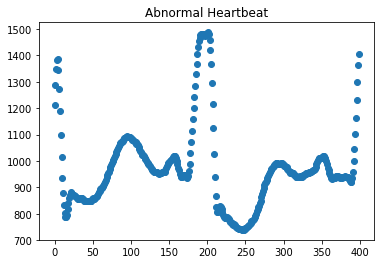

In [156]:
k = 3
print('Ex Number: ' + str(k))
print('Label: ' + str(dat[k][1]))

plt.scatter(range(len(dat[k][2])),dat[k][2])
plt.title('Abnormal Heartbeat')

In [1]:
from sklearn.manifold import TSNE

num = 300
dat = data.generate_data_batch('213',num,0)

X_d = sci.array(list(map(lambda x: sci.array(x[2]), dat)))
y_d = sci.reshape(sci.array(list(map(lambda x: sci.array(x[1]), dat))),[num,1])
y_d = 1.0*(y_d=='V')

vis = TSNE(random_state=100)
vis.fit(X_d)
plt.scatter(x=vis.embedding_[:,0],y=vis.embedding_[:,1],c=(y_d))

NameError: name 'data' is not defined

# Classification Attempts

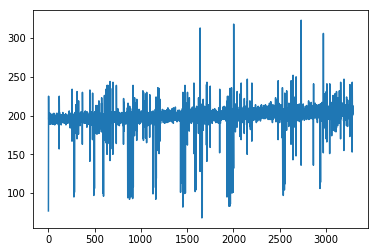

In [112]:
d = sci.diff(annot_str['index'])
plt.plot(d)

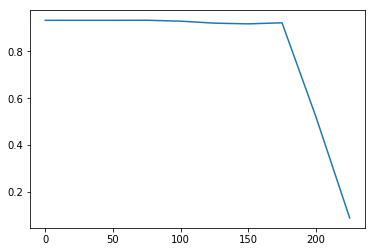

In [113]:
acc = []
t =  [0,25,50,75,100,125,150,175,200,225]
for threshold in t:
    outliers = sci.array(d < threshold)
    PVC = sci.array(annot_str['sym'] == 'V')[1:]

    acc.append(sci.mean(sci.equal(PVC,outliers)))

plt.plot(t,acc)

In [114]:
from sklearn.metrics import confusion_matrix

outliers = sci.array(d < 150)
PVC = sci.array(annot_str['sym'] == 'V')[1:]

confusion_matrix(PVC,outliers)

array([[2999,   74],
       [ 196,   24]])

## Neural net 

In [134]:
import tensorflow as tf

class ECG_classifier(object):
    """PVC Classifier for ECG signal from a single patient."""
    def __init__(self,window_size=400):
        self.window_size = 400

        self.database = MIT_BIH_parse(self.window_size)
        self.database.read_single_record('213')

        # Dynamic Parameters
        self.learning_rate = 0.005
        self.reg_rate = 0.001

        # Static Parameters
        self.param_size = 0.01
        self.num_classes = 2
        self.num_hidden_1 = 50
        self.alpha = 0.5        


    def init_tf_classifier(self):
        # Input Data
        self.X_in = tf.placeholder(tf.float64,[None,self.window_size])
        self.y_in = tf.placeholder(tf.int64,[None,1])

        # Derived Parameters
        # Number of examples
        self.m = tf.stack(tf.gather(tf.shape(self.X_in),0))
        self.y_one_hot = tf.cast(tf.reshape(tf.one_hot(self.y_in,2,on_value=1,off_value=0),[self.m,self.num_classes]),tf.float64)
        
        # Model Parameters
        self.W1 = tf.Variable(tf.truncated_normal([self.window_size,self.num_hidden_1],
                                                mean=0,
                                                stddev=self.param_size,
                                                dtype=tf.float64))
        self.b1 = tf.Variable(tf.zeros([1,self.num_hidden_1],dtype=tf.float64))

        self.W2 = tf.Variable(tf.truncated_normal([self.num_hidden_1,self.num_classes],
                                                mean=0,
                                                stddev=self.param_size,
                                                dtype=tf.float64))
        self.b2 = tf.Variable(tf.zeros([1,self.num_classes],dtype=tf.float64))

        # Inference
        self.y_hat = tf.matmul(tf.sigmoid(tf.matmul(self.X_in,self.W1) + self.b1),self.W2) + self.b2
        self.p_hat = tf.sigmoid(self.y_hat)
        self.guess = tf.argmax(self.p_hat,1)

        # Error Measure
        self.E = (1/self.m)*tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y_one_hot,logits=self.y_hat)) + self.reg_rate*(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2)))
        
        # Gradient computation and local search
        self.opt = tf.train.GradientDescentOptimizer(self.learning_rate)
        self.grad = self.opt.compute_gradients(self.E)
        
        self.train_step = self.opt.apply_gradients(self.grad)
        
        self.init = tf.global_variables_initializer()
        
    def init_tf_session(self,record_num):
        self.sess = tf.Session()
        batch_x,batch_y = self.generate_data_batch(str(record_num))
        self.sess.run(self.init,feed_dict={self.X_in:batch_x,self.y_in:batch_y})

    # Run stochastic gd for num_iter iterations
    def sgd(self,num_iter,record_num):
        train_error_per_iter = []
        val_error_per_iter = []
        for i in range(num_iter):
            # Run SGD iteration
            batch_x_train,batch_y_train = self.generate_data_batch(record_num)
            e,_ = self.sess.run([self.E,self.train_step],feed_dict={self.X_in:batch_x_train,self.y_in:batch_y_train})
            train_error_per_iter.append(e)

            # Dynamic parameter updates -- inactive
            #self.update_params(self.learning_rate,self.reg_rate,self.batch_size,self.param_size)
            batch_x_val,batch_y_val = self.generate_data_batch(record_num)
            e_val = self.sess.run([self.E],feed_dict={self.X_in:batch_x_val,self.y_in:batch_y_val})
            val_error_per_iter.append(e_val)
        return train_error_per_iter,val_error_per_iter
    
    # Generate data batch using class parameters
    def generate_data_batch(self,record_num,n=100,channel=0):
        dat = self.database.generate_data_batch(record_num,n,channel)

        X = sci.array(list(map(lambda x: sci.array(x[2]), dat)))
        y = sci.reshape(sci.array(list(map(lambda x: sci.array(x[1]), dat))),[n,1])
        y = 1.0*(y=='V')
        return X,y

    def predict_batch(self,record_num,n=100):
        X,y = self.generate_data_batch(record_num,n)
        return y,self.sess.run(self.guess,feed_dict={self.X_in:X})

    def update_params(self,learning_rate,reg_rate,batch_size,param_size,nhidden):
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.param_size = param_size
        self.reg_rate = reg_rate
        self.num_hidden_1 = nhidden

    def show_params(self):
        print('Learning Rate: ' + str(self.learning_rate))
        print('Regularization Rate: ' + str(self.reg_rate))
        print('Batch Size: ' + str(self.batch_size))
        print('Param Size: ' + str(self.param_size))
        print('Number of Hidden Units: ' + str(self.num_hidden_1))

In [135]:
c = ECG_classifier()

In [136]:
c.init_tf_classifier()

In [137]:
a = []
b = []

In [138]:
# parameter ordering
# learning rate
# regularization
# batch size
# parameter size
# number of hidden units
c.update_params(0.1,0.1,100,0.1,50)
c.init_tf_session('213')

In [139]:
tr,val = c.sgd(200,'213')
a = a + tr
b = b + val

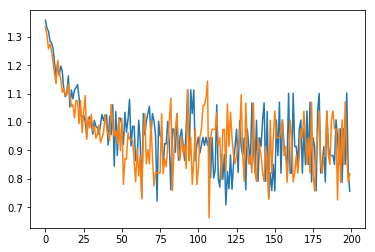

In [140]:
plt.plot(a)
plt.plot(b)

In [141]:
c.show_params()

Learning Rate: 0.1
Regularization Rate: 0.1
Batch Size: 100
Param Size: 0.1
Number of Hidden Units: 50


In [142]:
# Validation
y,pred = c.predict_batch('213',1000)
sci.mean(pred == y.T[0])

0.83999999999999997

In [143]:
confusion_matrix(y,pred)

array([[840,   0],
       [160,   0]])